# Exploratory data analysis (EDA) on Kaggle "House Prices - Advanced Regression Techniques" Dataset

## What is the business problem?

### Who might benefit from this project?  How? 
- Housing companies like Zillow or Redfin, maybe banks, could also help buyers and sellers to know how to predict house values

### What is the goal?
- Train a model on house values given certain inputs
1. Analyze house dataset for actionable insights
2. Create model with .138 or lower log RMSE

## Library imports

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
np.set_printoptions(legacy="1.25")
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy

from sklearn import set_config
set_config(transform_output='pandas')

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, 
                             mean_absolute_percentage_error, root_mean_squared_error)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, plot_tree


import category_encoders as ce
from category_encoders.hashing import HashingEncoder
from category_encoders.ordinal import OrdinalEncoder

from xgboost import XGBRegressor

## Load dataset

In [4]:
train_file_path = "../../house-prices-advanced-regression-techniques/input/train.csv"
houses = pd.read_csv(train_file_path)
print("Full training dataset shape is {}".format(houses.shape))

Full training dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can look at all 81 dimensions of our dataset by printing out the first 5 entries and changing our max column display:

In [5]:
pd.set_option('display.max_columns', 85) # Shows up to 85 columns
houses.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [6]:
houses["Id"].value_counts().sum() == houses.shape[0] 
# True so Id column is unique per row

True

In [7]:
houses = houses.drop('Id', axis=1) # drop "Id" column as it's not necessary for model training
houses.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [8]:
houses.drop_duplicates(inplace=True) # drop any duplicates
print("Modified training dataset shape is {}".format(houses.shape))

Modified training dataset shape is (1460, 80)


In [9]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## What are we looking at?

### What is the source of the data?
- Kaggle competition dataset

### What does it describe? (What is a row?)
- All the characteristics of a house. Seemingly a row is a house.

### What is the shape of the data?
- The shape of the DataFrame is 1460 observations (rows), 80 features (columns)
- There are 37 numeric and 43 object features
- There are 79 features for use in predicting the house sale price indicated by target column `SalePrice`

## House Price Distribution

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


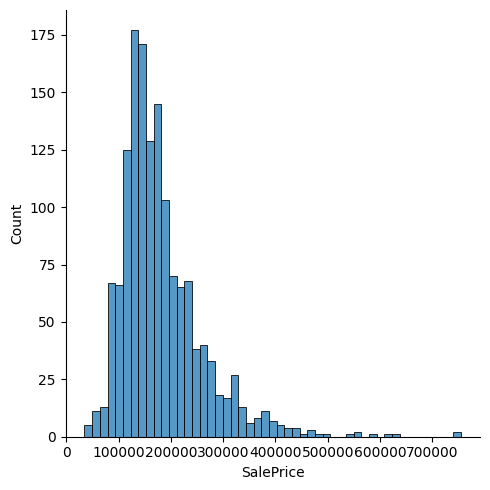

In [10]:
print(houses['SalePrice'].describe())
sns.displot(houses['SalePrice'], kind="hist")
plt.tight_layout();

Looks skewed right but generally a normal distribution.

## Numerical data distribution & model

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones. Then we will strip/impute to create a baseline model to get a baseline log RMSE (evaluation criteria)

In [11]:
houses.dtypes.value_counts()

object     43
int64      34
float64     3
Name: count, dtype: int64

In [12]:
df_num = houses.select_dtypes(include=['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


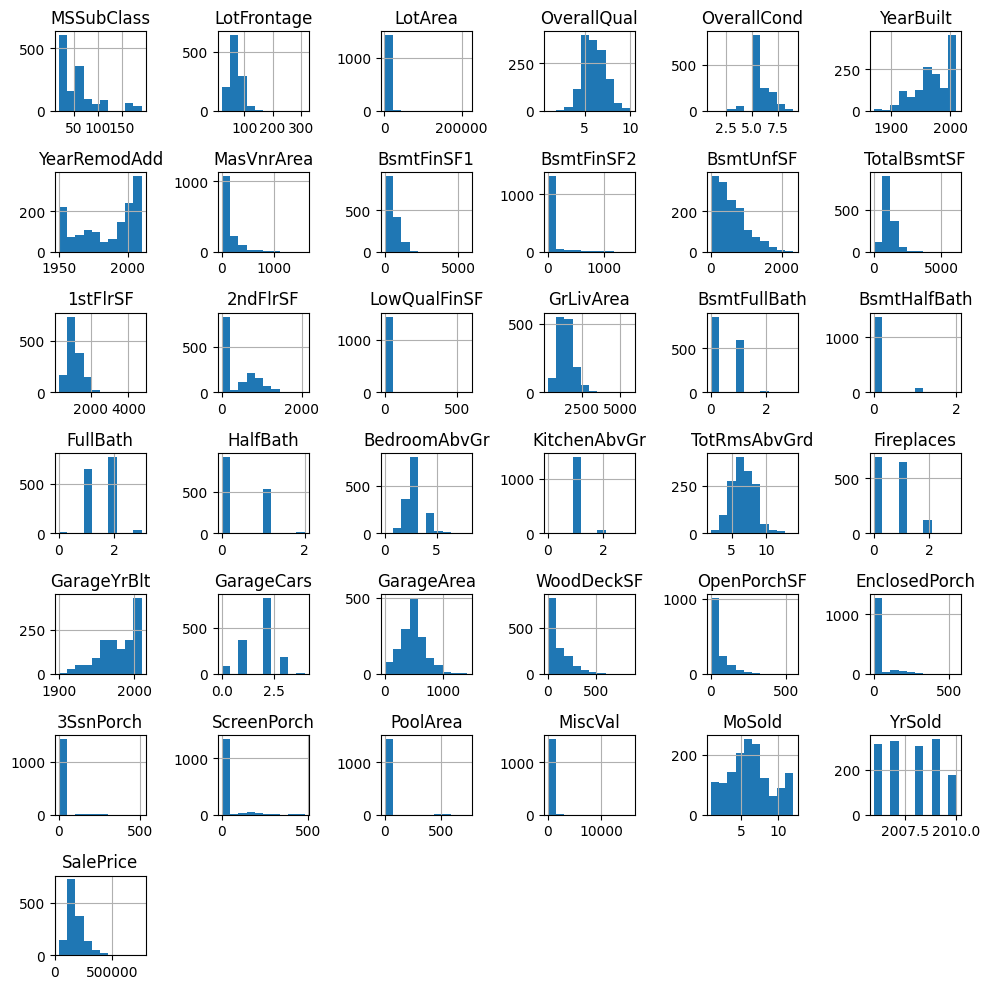

In [13]:
df_num.hist(figsize=(10,10))
plt.tight_layout();

### Build preliminary model with numerical data

In [14]:
df_num.dropna(inplace=True) # drop any NaNs
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1121 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1121 non-null   int64  
 1   LotFrontage    1121 non-null   float64
 2   LotArea        1121 non-null   int64  
 3   OverallQual    1121 non-null   int64  
 4   OverallCond    1121 non-null   int64  
 5   YearBuilt      1121 non-null   int64  
 6   YearRemodAdd   1121 non-null   int64  
 7   MasVnrArea     1121 non-null   float64
 8   BsmtFinSF1     1121 non-null   int64  
 9   BsmtFinSF2     1121 non-null   int64  
 10  BsmtUnfSF      1121 non-null   int64  
 11  TotalBsmtSF    1121 non-null   int64  
 12  1stFlrSF       1121 non-null   int64  
 13  2ndFlrSF       1121 non-null   int64  
 14  LowQualFinSF   1121 non-null   int64  
 15  GrLivArea      1121 non-null   int64  
 16  BsmtFullBath   1121 non-null   int64  
 17  BsmtHalfBath   1121 non-null   int64  
 18  FullBath     

Looks like we have a fully numeric dataset with no missing values so let's build a model!

In [15]:
X_num = df_num.drop(columns = "SalePrice")
y_num = df_num["SalePrice"].copy()

In [16]:
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_num, y_num, test_size=.2, random_state=42)
# X_num_val, X_num_test, y_num_val, y_num_test = train_test_split(X_num_test, y_num_test, test_size=.5, random_state=42)

In [17]:
rf_num = RandomForestRegressor(random_state=42)
rf_num.fit(X_num_train, y_num_train)

RandomForestRegressor(random_state=42)

In [18]:
num_train_pred = rf_num.predict(X_num_train)
rf_num_RMSE_train = root_mean_squared_error(np.log1p(y_num_train), np.log1p(num_train_pred))
rf_num_RMSE_train

0.06580671711184483

In [19]:
num_test_pred = rf_num.predict(X_num_test)
rf_num_RMSE_test = root_mean_squared_error(np.log1p(y_num_test), np.log1p(num_test_pred))
rf_num_RMSE_test

0.13116492334564084

In [20]:
# num_val_pred = rf_num.predict(X_num_val)
# rf_num_RMSE_val = root_mean_squared_error(np.log1p(y_num_val), np.log1p(num_val_pred))
# rf_num_RMSE_val

# Baseline Submission
Submitting predictions on the competition test data using the baseline model.

In [21]:
test_file_path = "../../house-prices-advanced-regression-techniques/input/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop("Id")

preds = rf_num.predict(test_data[X_num.columns])
output = pd.DataFrame({"Id": ids,
                       "SalePrice": preds})

output.head()

,Id,SalePrice
0,1461,123095.66
1,1462,155594.00
2,1463,187684.40
3,1464,185909.33
4,1465,212736.98


In [22]:
sample_submission_file_path = "../../house-prices-advanced-regression-techniques/input/sample_submission.csv"
sample_submission_df = pd.read_csv(sample_submission_file_path)
sample_submission_df["SalePrice"] = preds
sample_submission_df.to_csv("00_baseline_submission.csv", index=False)
sample_submission_df.head()

,Id,SalePrice
0,1461,123095.66
1,1462,155594.00
2,1463,187684.40
3,1464,185909.33
4,1465,212736.98


# Continuing EDA

# Columns
## Index
Id

## Object Columns
MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition
### Ordinal

### Binary

### Nominal (non-binary)
1. Home Ownership (trinary)
2. Purpose

## Numeric Columns
MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
PoolQC
Fence
MiscFeature
MiscVal
MoSold
YrSold
SaleType
SaleCondition

# Target
SalePrice


In [48]:
# some basic methods to understand the DataFrame
houses.info(); 
display(f"The shape of the DataFrame is {houses.shape}");
display(f"The number of duplicated rows is {houses.duplicated().sum()}");
houses.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

'The shape of the DataFrame is (1460, 80)'

'The number of duplicated rows is 0'

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [49]:
(houses.isna().sum().sort_values(ascending=False).head(20)/houses.shape[0]).round(4)*100
# 19 columns with null values upon initial inspection
# displayed as percent of missing numbers in data per column

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
MasVnrType      59.73
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtCond         2.53
BsmtQual         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
Electrical       0.07
MSSubClass       0.00
dtype: float64

From data_description we know `PoolQC` and `Alley` NaN mean there is no pool/alley. Let's impute 0 for NaN later. Let's drop MiscFeature since the price of misc features in included in MiscVal and I believe that will help our model more that too many NaNs. Now let's examine `Fence`, `MasVnrType`, and `FireplaceQu` with an intention to drop or impute for other null columns later.

In [51]:
houses[["Fence", "MasVnrType", "FireplaceQu"]]

,Fence,MasVnrType,FireplaceQu
0,NaN,BrkFace,NaN
1,NaN,NaN,TA
2,NaN,BrkFace,TA
3,NaN,NaN,Gd
4,NaN,BrkFace,TA
...,...,...,...
1455,NaN,NaN,TA
1456,MnPrv,Stone,TA
1457,GdPrv,NaN,Gd
1458,NaN,NaN,NaN


In [57]:
display(houses["Fence"].value_counts())
# good to do nominal encoding and impute 0 for nulls
display(houses["MasVnrType"].value_counts())
# good to do nominal encoding and impute 0 for nulls
display(houses["FireplaceQu"].value_counts())
# using description, need to ordinal encode:
    # Ex	Excellent - Exceptional Masonry Fireplace
    # Gd	Good - Masonry Fireplace in main level
    # TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
    # Fa	Fair - Prefabricated Fireplace in basement
    # Po	Poor - Ben Franklin Stove
    # NA	No Fireplace
# will impute 0 for nulls and rank 5 to 1 from Ex to Po

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64

In [80]:
# looking back at other NaN columns
(houses.isna().sum().sort_values(ascending=False).head(20)/houses.shape[0]).round(4)*100

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
MasVnrType      59.73
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtCond         2.53
BsmtQual         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
Electrical       0.07
MSSubClass       0.00
dtype: float64

After consulting data_description, will impute 0 for other columns with NaNs